# Text Classification  -  Sentiment Analysis

- Apply Text Vectorization TfIdfVectorization and CounterVectorization
- Apply Neural Network model to predict whether the rating is positive or nagative

##  Required packages

In [14]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

import itertools


from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler

from keras import models
from keras import layers
from tensorflow.keras.optimizers import Adam

from time import time
from sklearn import metrics

# import customised plotting functions from plot_mtrics.py script
from plot_metrics import plot_radar_metrics, plot_radar_mult, barplot_metric_mult, \
                        lineplot_metrics, stack_barplot, \
                        barplot_model_vs_metrics_group, barplot_models_group_vs_metric


## Load data

In [4]:
# load the data
df = pd.read_csv("data_to_vect.csv" , index_col=0)

# display first lines of the data
display(df.head())

# check nan values
print(df.isna().sum())

print(df.info())

,comment,rating,comment_cleaned,comment_lemmatized,comment_stem,stem_len
0,"Facilte, sollicitations dosées...qualité..on p...",4,facilte sollicitations dosées qualité pourrait...,facilte sollicitation doser qualité pouvoir ce...,facilt sollicit dos qualit pouvoir cepend amél...,558
1,Livraison impeccable avec possibilité de prend...,4,livraison impeccable possibilité prendre samed...,livraison impeccable possibilité prendre samed...,livraison impecc possibil prendr samed matin b...,461
2,Achat d'un canapé La Redoute intérieurs le 6/9...,4,achat canapé redoute intérieurs site redoute a...,achat canapé redoute intérieur site redoute ab...,achat canap redout intérieur sit redout abord ...,426
3,je commande depuis longtemps chez la redoute; ...,4,commande depuis longtemps redoute appréciais c...,commande depuis longtemps redoute appréciai ch...,command depuis longtemp redout appréci choix r...,370
4,"Comme d'habitude, aucun souci et rapidité d'ex...",5,habitude aucun souci rapidité expédition colis...,habitude aucun souci rapidité expédition colis...,habitud aucun souc rapid expédit colis bravo d...,366


comment               0
rating                0
comment_cleaned       0
comment_lemmatized    0
comment_stem          0
stem_len              0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 22683 entries, 0 to 23466
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   comment             22683 non-null  object
 1   rating              22683 non-null  int64 
 2   comment_cleaned     22683 non-null  object
 3   comment_lemmatized  22683 non-null  object
 4   comment_stem        22683 non-null  object
 5   stem_len            22683 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.2+ MB
None


## Split data into training and test data
- Set the test size at 25% of the overall sample.
- Set stratify = y to preserve the repartition of labels on training and test data

In [5]:
# the target variable is 0 if rating <= 3 and 1 if rating >= 4
y = (df["rating"]>3)*1  

# explanatory variable : the stemmed comment
X = df["comment_stem"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, stratify=y, random_state=23)


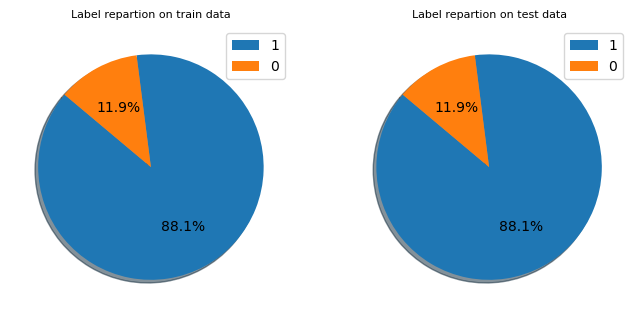

In [6]:
#Label repartition on train data and on test data
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.pie(y_train.value_counts(), autopct='%1.1f%%', shadow=True, startangle=140)
plt.legend(labels=['1', '0'])
plt.title('Label repartion on train data', fontsize=8)
plt.axis('off')

plt.subplot(1,2,2)
plt.pie(y_test.value_counts(), autopct='%1.1f%%', shadow=True, startangle=140)
plt.legend(labels=['1', '0'])
plt.title('Label repartion on test data', fontsize=8)
plt.axis('off');
plt.show()

## Preprocessing 
### Preprocessing with TF-IDF
- TF-IDF
- RandomUnderSampling

In [7]:
#vectorizer = TfidfVectorizer(min_df=5, max_df = 0.8, sublinear_tf=True, use_idf=True)
tfvectorizer = TfidfVectorizer()

V_train = tfvectorizer.fit_transform(X_train).toarray()
V_test = tfvectorizer.transform(X_test).toarray()

# Undersampling to tackle classes imbalance
ru = RandomUnderSampler()
V_ru, y_ru = ru.fit_resample(V_train, y_train)


In [8]:
print(V_ru.shape)
print(y_ru.shape)

(4034, 5118)
(4034,)


##  Models training and Evaluation

### Function to fit and evaluate a neural network model

In [10]:
#function to fit and evaluate a neural network model

def fit_and_evaluate_nn(model_name, model, 
                        epochs=10, 
                        batch_size=250,
                        class_weight=None,
                        callbacks=None):
    """ Function to train neural network 'mode', evaluate model_1 performance.
        output: dataframe of metrics scores, confusion matrix, classification report
    """
    t0 = time() 
    hsistory = model.fit(V_ru, y_ru,
                         epochs=30,
                         batch_size=405,
                         class_weight=class_weight,
                         callbacks=callbacks,
                         validation_data = (V_test, y_test))
    
    time_train = time()-t0 # record training duration
    
    results = model.evaluate(V_test, y_test)
    print("results:", results)

    # prediction
    t1 = time()
    pred = model.predict(V_test)
    time_predict = time() - t1  # records duration of predicting
    prediction = (1*(pred>=0.5))[:,0]

    accuracy = results[1]
    # The balanced accuracy in binary and multiclass classification problems 
    # to deal with imbalanced datasets.
    # It is defined as the average of recall obtained on each class.
    # The best value is 1 and the worst value is 0 when adjusted=False.
    balanced_accuracy = metrics.balanced_accuracy_score(y_test, prediction)   
    
    f1_score = metrics.f1_score(y_test, prediction)
    f1_score_macro = metrics.f1_score(y_test, prediction, average="macro")
    f1_score_weighted = metrics.f1_score(y_test, prediction, average="weighted")
    
    recall = metrics.recall_score(y_test, prediction, pos_label=0)
    recall_macro = metrics.recall_score(y_test, prediction, average="macro")
    recall_weighted = metrics.recall_score(y_test, prediction, average="weighted")
    
    # precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
    # we set pos_label=0 : that is negative rating (rating <=3)
    precision = metrics.precision_score(y_test, prediction, pos_label=0)
    precision_macro = metrics.precision_score(y_test, prediction, average="macro" )
    precision_weighted = metrics.precision_score(y_test, prediction, average="weighted")

    cl_report = metrics.classification_report(y_test, prediction)
    cf_matrix = pd.crosstab(y_test, prediction, rownames = ["Real"], colnames=["Prediction"])

    # put metrics into a dictionnary and into a DataFrame
    res = {"model": model_name, 
           "accuracy": accuracy, "balanced_accuracy": balanced_accuracy, 
           "f1": f1_score, "f1_macro": f1_score_macro, "f1_weighted": f1_score_weighted,
           "recall_0": recall, "recall_macro": recall_macro, "recall_weighted": recall_weighted,
           "precision_0" : precision, "precision_macro" : precision_macro, "precision_weighted" : precision_weighted,
            "time_train":time_train, "time_predict": time_predict}

    #DataFrame of model's performance
    df_p = pd.DataFrame(res, index=[0])

    #output model performance, classification report and confusion matrix
    return (df_p, cl_report, cf_matrix)


### Dense Neural Network

In [11]:
y_ru = np.asarray(y_ru).astype('float32')
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

In [12]:
V_ru.shape[1]

5118

In [24]:
model_name = "tfidf_dense_nn0"
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(V_ru.shape[1],)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

df_p_dnn, cl_report_dnn, cf_matrix_dnn = fit_and_evaluate_nn(model_name, model, epochs=20, batch_size=250)

# Save performance data in a csv file
file_name = "perf_tfidf_"+model_name+".csv"
df_p_dnn.to_csv(file_name)

# Radar chart of model's performance
data = df_p_dnn.iloc[:,:-2]
plot_radar_metrics(data, model_name)

# Barplot of models performance
# Comparision with TfidfVectorizr & Logistic Regression 
model_list=[model_name]
barplot_models_group_vs_metric(data, model_list)


#display confusion matrix and classification report
display(cf_matrix_dnn)
print(cl_report_dnn)

Epoch 1/30
10/10 [==============================] - 1s 46ms/step - loss: 0.6886 - accuracy: 0.7030 - val_loss: 0.6833 - val_accuracy: 0.7586
Epoch 2/30
10/10 [==============================] - 0s 13ms/step - loss: 0.6683 - accuracy: 0.8624 - val_loss: 0.6640 - val_accuracy: 0.7708
Epoch 3/30
10/10 [==============================] - 0s 14ms/step - loss: 0.6319 - accuracy: 0.8845 - val_loss: 0.6323 - val_accuracy: 0.7829
Epoch 4/30
10/10 [==============================] - 0s 14ms/step - loss: 0.5791 - accuracy: 0.8964 - val_loss: 0.5866 - val_accuracy: 0.8013
Epoch 5/30
10/10 [==============================] - 0s 14ms/step - loss: 0.5109 - accuracy: 0.9043 - val_loss: 0.5333 - val_accuracy: 0.8101
Epoch 6/30
10/10 [==============================] - 0s 13ms/step - loss: 0.4332 - accuracy: 0.9108 - val_loss: 0.4681 - val_accuracy: 0.8309
Epoch 7/30
10/10 [==============================] - 0s 14ms/step - loss: 0.3586 - accuracy: 0.9212 - val_loss: 0.4148 - val_accuracy: 0.8402
Epoch 8/30
10

Prediction,0,1
Real,,
0.0,586,87
1.0,757,4241


              precision    recall  f1-score   support

         0.0       0.44      0.87      0.58       673
         1.0       0.98      0.85      0.91      4998

    accuracy                           0.85      5671
   macro avg       0.71      0.86      0.75      5671
weighted avg       0.92      0.85      0.87      5671



In [30]:
# 2eme modèle
model_name = "tfidf_dense_nn1"
model = models.Sequential()
model.add(layers.Dense(48, activation='relu', input_shape=(V_ru.shape[1],)))
model.add(layers.Dense(24, activation='relu', input_shape=(V_ru.shape[1],)))
model.add(layers.Dense(12, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

df_p_dnn, cl_report_dnn, cf_matrix_dnn = fit_and_evaluate_nn(model_name, model, epochs=50, batch_size=250)

# Save performance data in a csv file
file_name = "perf_tfidf_"+model_name+".csv"
df_p_dnn.to_csv(file_name)

# Radar chart of model's performance
data = df_p_dnn.iloc[:,:-2]
plot_radar_metrics(data, model_name)

# Barplot of models performance
# Comparision with TfidfVectorizr & Logistic Regression 
model_list=[model_name]
barplot_models_group_vs_metric(data, model_list)


#display confusion matrix and classification report
display(cf_matrix_dnn)
print(cl_report_dnn)

Epoch 1/30
10/10 [==============================] - 1s 51ms/step - loss: 0.6877 - accuracy: 0.6901 - val_loss: 0.6792 - val_accuracy: 0.7582
Epoch 2/30
10/10 [==============================] - 0s 15ms/step - loss: 0.6567 - accuracy: 0.8704 - val_loss: 0.6420 - val_accuracy: 0.8057
Epoch 3/30
10/10 [==============================] - 0s 15ms/step - loss: 0.5966 - accuracy: 0.9031 - val_loss: 0.5759 - val_accuracy: 0.8369
Epoch 4/30
10/10 [==============================] - 0s 17ms/step - loss: 0.5100 - accuracy: 0.9137 - val_loss: 0.4965 - val_accuracy: 0.8473
Epoch 5/30
10/10 [==============================] - 0s 16ms/step - loss: 0.4089 - accuracy: 0.9199 - val_loss: 0.4136 - val_accuracy: 0.8595
Epoch 6/30
10/10 [==============================] - 0s 16ms/step - loss: 0.3136 - accuracy: 0.9259 - val_loss: 0.3555 - val_accuracy: 0.8630
Epoch 7/30
10/10 [==============================] - 0s 17ms/step - loss: 0.2396 - accuracy: 0.9323 - val_loss: 0.3173 - val_accuracy: 0.8700
Epoch 8/30
10

Prediction,0,1
Real,,
0.0,583,90
1.0,744,4254


              precision    recall  f1-score   support

         0.0       0.44      0.87      0.58       673
         1.0       0.98      0.85      0.91      4998

    accuracy                           0.85      5671
   macro avg       0.71      0.86      0.75      5671
weighted avg       0.92      0.85      0.87      5671

